In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

**Modify the previous code to solve the following the problem:**

Consider 2D heat transfer across a plate  of thermal conductivity $k = 50 $ shown in the figure below

\begin{align}
-k\Delta u & = f, & \mbox{ in } & \Omega\\
u & = T_0, & \mbox{ on sides: } & AB \cup CD \cup EF \cup GH\\
k \nabla T \cdot {\bf n}  & = g, & \mbox{  on sides: } & BC \cup DE \cup FG \cup HA  
\end{align}
where
$$f(x,y) = x^2 + y^2,$$
$$T_0 = 350,$$
$$g(x,y) = 100.$$


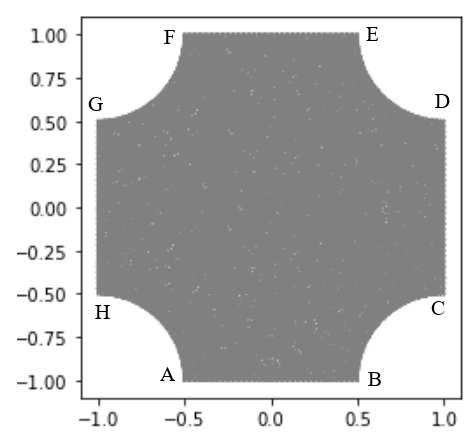

dim(Vh) =  4871


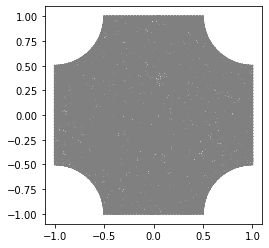

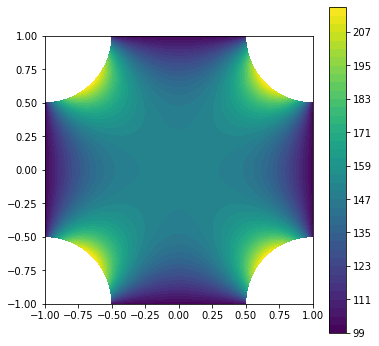

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
#
%matplotlib inline
A = Point ( -1.0, -1.0 )
B = Point ( 1.0, 1.0 )
radius = 0.5

domain = Rectangle(A,B) - Circle(Point(1,1),radius) - Circle(Point(-1,1),radius) -\
                           Circle(Point(-1,-1),radius) - Circle(Point(1,-1),radius)

mesh = generate_mesh (domain ,50)
plot(mesh)
#
d = 1
Vh  = FunctionSpace(mesh, 'Lagrange', d)
print ("dim(Vh) = ", Vh.dim())
#
k = Constant(50.)
T0 = Constant(100.0)
g   = Constant(350.) # gamma boundary

f = Expression('x[0]*x[0] + x[1]*x[1]', degree=d+2)
#
#  Define Dirichlet boundary condition
#
def TopBoundary(x, on_boundary):
  return on_boundary and near(x[1] , 1)

bc_1 = DirichletBC(Vh, T0, TopBoundary)
#
def BottomBoundary(x, on_boundary):
  return on_boundary and near(x[1] , -1)

bc_2 = DirichletBC(Vh, T0, BottomBoundary)
#
def LeftBoundary(x, on_boundary):
  return on_boundary and near(x[0] , -1)

bc_3 = DirichletBC(Vh, T0, LeftBoundary)
#
def RightBoundary(x, on_boundary):
  return on_boundary and near(x[0] ,1)

bc_4 = DirichletBC(Vh, T0, RightBoundary)
#
bcs = [bc_1, bc_2, bc_3, bc_4]
#
# Define boundary labels
#
class Top_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] -1)**2 + (x[1] - 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

class Top_Left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +1)**2 + (x[1] - 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

class Bottom_left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +1 )**2 + (x[1] + 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

class Bottom_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] - 1)**2 + (x[1] + 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
# mark the entire boundary as 0
boundary_parts.set_all(0)

# Mark the boundaries as subdomains  1, 2, 3 and 4
top_right_hole = Top_Right_hole()
top_right_hole.mark(boundary_parts, 1)

top_Left_hole = Top_Left_hole()
top_Left_hole.mark(boundary_parts, 2)

bottom_left_hole = Bottom_left_hole()
bottom_left_hole.mark(boundary_parts, 3)

bottom_Right_hole = Bottom_Right_hole()
bottom_Right_hole.mark(boundary_parts, 4)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)
#
u = TrialFunction(Vh)
v = TestFunction(Vh)
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx + g*v*ds(1) + g*v*ds(2) + g*v*ds(3) +  g*v*ds(4)
#
uh = Function(Vh)
solve(a == L, uh, bcs=bcs)
#
# Plot solution
plt.figure(figsize=(6,6))
p=plot(uh)
plt.colorbar(p)
plt.show()